In [2]:
from utils import * 
import os 
from src.ggkbase import * 
import glob
import matplotlib as mpl 
from src.files import BLASTFileJSON, FASTAFile, InterProScanFileTSV, GenBankFile, fasta_get_genome_size
import subprocess
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap, to_hex
from src.metat import metat_load
from scipy.stats import gmean 

%load_ext autoreload
%autoreload 2

In [3]:
coverm_df = coverm_load('../data/coverm/all.tsv', contig_sizes=contig_sizes)
coverm_df = coverm_df[coverm_df.reactor != 'none'].copy()
metat_df = metat_load()
bbduk_df = bbduk_load('../data/bbduk')

In [20]:
cmap_blues = LinearSegmentedColormap.from_list('blues', ['lightblue', 'steelblue'])
cmap_white_to_blue = LinearSegmentedColormap.from_list('blues', ['white', 'steelblue'])
cmap_grays = LinearSegmentedColormap.from_list('grays', ['lightgray', 'gray'])

def cmap_sample(cmap, n):
    return [to_hex(color) for color in cmap(np.linspace(0, 1, n))]

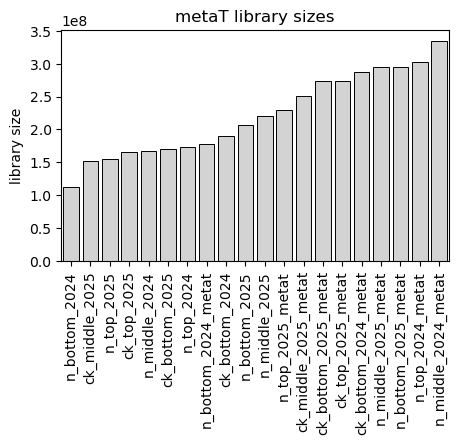

In [5]:

fig, ax = plt.subplots(figsize=(5, 3))
figure_df =  bbduk_df[bbduk_df.index.str.contains('ck_|n_')].copy() # Bioreactor samples only.
figure_df = figure_df.reset_index(drop=False) 
figure_df = figure_df.sort_values('library_size')
sns.barplot(figure_df, y='library_size', x='sample_id', color='lightgray', edgecolor='black', lw=0.7) #, hue='library_size', palette='Grays', legend=False)
ax.set_xlabel('')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
ax.set_ylabel('library size')
ax.set_title('metaT library sizes')
plt.show()
# for row in bbduk_df[bbduk_df.index.str.contains('ck_|n_')].itertuples():
#     print(row.Index, row.library_size)

# Library sizes range from around 150,000,000 to 350,000,000. Probably want to be more lenient than not, so select a CPM
# which could correspond to a count of ~5 for 1e8, or (5 / (1e8 / 1e6))

In [6]:

def remove_low_abundance_genomes(coverm_df, min_rpkm:float=1, min_n_samples:int=1):
    include_genome_ids = coverm_df.groupby('genome_id').apply(lambda df : (df.rpkm > min_rpkm).sum() > min_n_samples, include_groups=False)
    include_genome_ids = include_genome_ids[include_genome_ids].index 
    n_genome_ids = coverm_df.genome_id.nunique()
    print(f'remove_low_abundance_genomes: Retaining {len(include_genome_ids)} out of {n_genome_ids} targets after filtering for abundance.')
    return coverm_df[coverm_df.genome_id.isin(include_genome_ids)].copy()


def plot_abundance(figure_df:pd.DataFrame, title=r'$\it{Methanoperedens}$ abundance', min_rpkm=1e-2, legend:bool=True, ax=None, genome_ids:list=None):

    figure_df = figure_df.sort_values(['sample_id', 'genome_id'], ascending=True)

    # figure_df = figure_df.copy()
    figure_df['year'] = [re.search(r'202\d', sample_id).group(0) for sample_id in figure_df.sample_id]
    figure_df = remove_low_abundance_genomes(figure_df, min_rpkm=min_rpkm).copy() if (genome_ids is None) else figure_df[figure_df.genome_id.isin(genome_ids)].copy()
    
    sample_ids = figure_df.sample_id.unique()
    n_samples = figure_df.sample_id.nunique()

    genome_ids = sorted(figure_df.genome_id.unique())
    palettes = dict()
    palettes['2024'] = dict(zip(genome_ids, cmap_sample(cmap_grays, len(genome_ids))))
    palettes['2025'] = dict(zip(genome_ids, cmap_sample(cmap_blues, len(genome_ids))))
    # print(palettes)

    bottom = np.zeros(n_samples)
    for genome_id, df in figure_df.groupby('genome_id'):
        colors = [palettes[year].get(genome_id, 'red') for year in df.year]
        heights = df.set_index('sample_id').rpkm.to_dict() # Make this robust to when some samples aren't present. 
        heights = np.array([heights.get(sample_id, 0) for sample_id in sample_ids])
        ax.bar(x=np.arange(n_samples), height=heights, bottom=bottom, label=genome_id, edgecolor='black', lw=0.7, color=colors)
        bottom += heights
    ax.set_title(title)
    ax.set_ylabel('RPKM')
    ax.set_xticks(np.arange(n_samples), labels=[sample_id.replace('_metat', '') for sample_id in sample_ids], rotation=90)

    if legend:
        handles = [Patch(edgecolor='black', linewidth=0.7, facecolor=palettes['2025'][genome_id]) for genome_id in genome_ids]
        ax.legend(handles, genome_ids)


remove_low_abundance_genomes: Retaining 4 out of 25 targets after filtering for abundance.


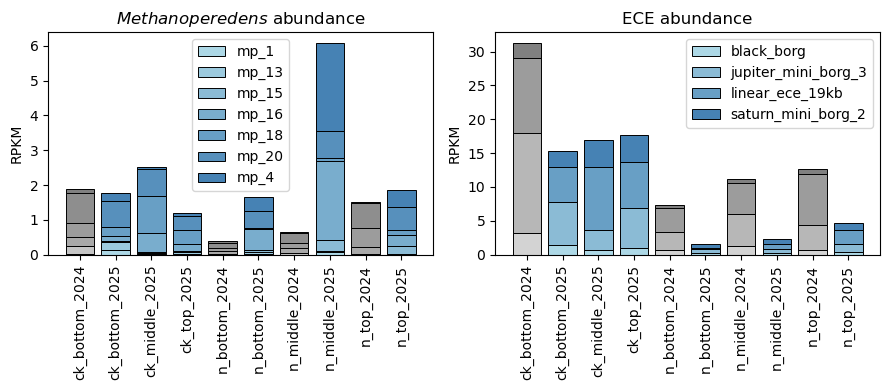

In [7]:
fig, (ax_a, ax_b) = plt.subplots(figsize=(9, 4), ncols=2)
mp_genome_ids = ['mp_1', 'mp_13', 'mp_15', 'mp_16', 'mp_18', 'mp_20', 'mp_4']

plot_abundance(coverm_df[is_mp(coverm_df)].copy(), ax=ax_a, title=r'$\it{Methanoperedens}$ abundance', min_rpkm=1e-1, genome_ids=mp_genome_ids)
plot_abundance(coverm_df[~is_mp(coverm_df)].copy(), ax=ax_b, title='ECE abundance', min_rpkm=1)

fig.tight_layout()
plt.show()

remove_low_abundance_genomes: Retaining 7 out of 20 targets after filtering for abundance.
remove_low_abundance_genomes: Retaining 4 out of 25 targets after filtering for abundance.


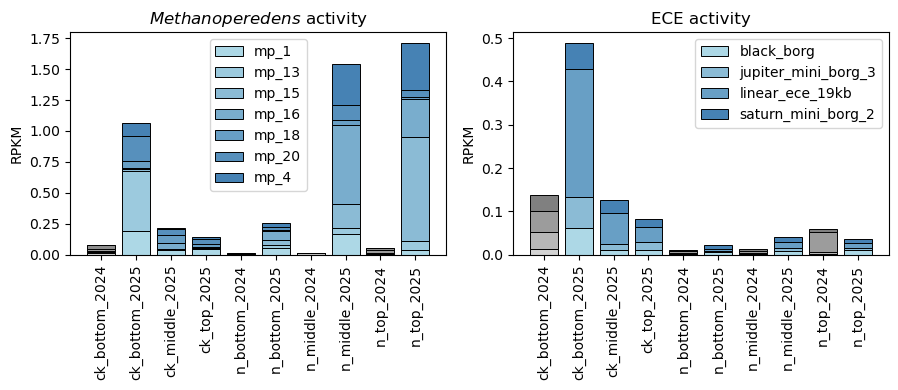

In [8]:
fig, (ax_a, ax_b) = plt.subplots(figsize=(9, 4), ncols=2)
# Initially had the thought that ECE-hosting Methanoperedens might appear to have lower activity if their transcriptional resources were being allocated
# to their ECEs, but this does not make much sense, as RPKM is dependent on genome size, and ECEs are much smaller than the host. ECE activity has a 
# negligible effect on overall RPKM.

# ece_genome_ids = ['black_borg', 'jupiter_mini_borg_3', 'linear_ece_19kb', 'saturn_mini_borg_2']
# figure_df['genome_id'] = figure_df.genome_id.replace({genome_id:'mp_2' for genome_id in ece_genome_ids})
figure_df = metat_df.copy()
figure_df = figure_df.groupby(['genome_id', 'sample_id']).agg({'read_count':'sum', 'length':'sum', 'library_size':'first'}).reset_index()
figure_df['rpkm'] = figure_df.read_count / (figure_df.length / 1e3) / (figure_df.library_size / 1e6)

plot_abundance(figure_df[is_mp(figure_df)], ax=ax_a, title=r'$\it{Methanoperedens}$ activity', min_rpkm=5e-2)
plot_abundance(figure_df[~is_mp(figure_df)], ax=ax_b, title='ECE activity', min_rpkm=1e-2)

fig.tight_layout()
plt.show()

In [9]:
# How best to visualize changes in composition? Probably a heatmap is best. 

def get_clr_normalization(df):
    df = df.copy()
    df['geometric_mean'] = df.sample_id.map(df.groupby('sample_id').apply(lambda df_ : scipy.stats.gmean(df_.rpkm), include_groups=False))
    df['rpkm_clr_normalized'] = np.log10(df.rpkm) - np.log10(df.geometric_mean)
    return df

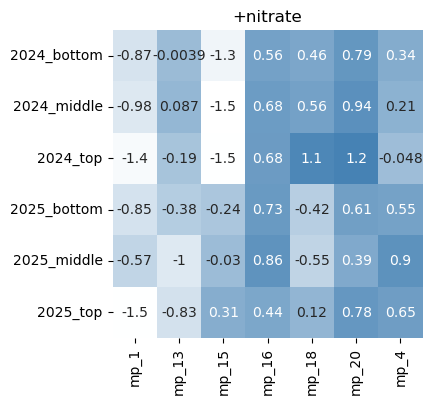

In [21]:

reformat_sample_id = lambda row : f'{row.year}_{row.location}'

reactor = 'n'
funcs = {'read_count':'sum', 'genome_size':'first', 'library_size':'first', 'year':'first', 'location':'first'}

figure_df = coverm_df.copy()
figure_df = figure_df[(figure_df.reactor == reactor) & figure_df.genome_id.isin(mp_genome_ids)].copy()
figure_df = figure_df.groupby(['genome_id', 'sample_id']).agg(funcs).reset_index()
figure_df['rpkm'] = figure_df.read_count / (figure_df.genome_size / 1e3) / (figure_df.library_size / 1e6)
figure_df = get_clr_normalization(figure_df)
figure_df['sample_id'] = [reformat_sample_id(row) for row in figure_df.itertuples()] 
figure_df = figure_df.sort_values('sample_id')

fig, ax = plt.subplots(figsize=(4, 4))
figure_df = figure_df.pivot(index='sample_id', columns='genome_id', values='rpkm_clr_normalized')
sns.heatmap(figure_df, cmap=cmap_white_to_blue, annot=True, cbar=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('+nitrate')
plt.show()

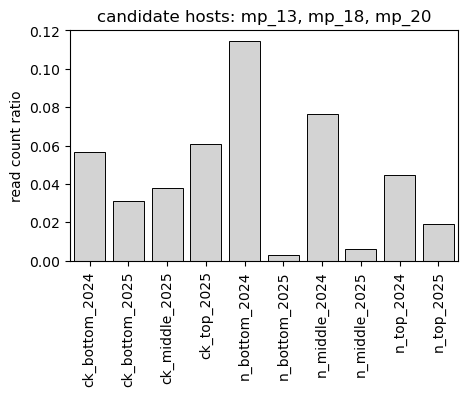

In [36]:
# What if we assume that mp_13 is the only host? What happens to the ratio?

host_genome_ids = ['mp_13', 'mp_18', 'mp_20']
host_read_counts = coverm_df[coverm_df.genome_id.isin(host_genome_ids)].groupby('sample_id').read_count.sum().to_dict()

figure_df = coverm_df[~is_mp(coverm_df)].copy()
figure_df['host_read_count'] = figure_df.sample_id.map(host_read_counts)
figure_df['read_count_ratio'] = figure_df.read_count / figure_df.host_read_count 
figure_df = figure_df[figure_df.genome_id == 'linear_ece_19kb'].sort_values(['reactor', 'location', 'year'])

fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(figure_df, x='sample_id', y='read_count_ratio', color='lightgray', lw=0.7, edgecolor='black')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
ax.set_ylabel('read count ratio')
ax.set_xlabel('')
ax.set_title(f'candidate hosts: {', '.join(host_genome_ids)}')
plt.show()

In [22]:
# figure_df = metat_df.copy()
# figure_df = figure_df[figure_df.genome_id.isin(mp_genome_ids)].copy()
# figure_df = figure_df.groupby(['genome_id', 'sample_id']).agg({'read_count':'sum', 'length':'sum', 'library_size':'first'}).reset_index()
# figure_df['rpkm'] = figure_df.read_count / (figure_df.length / 1e3) / (figure_df.library_size / 1e6)
# figure_df = get_clr_normalization(figure_df)
# figure_df = figure_df[figure_df.sample_id.str.startswith('n_')].copy()
# figure_df['sample_id'] = figure_df.sample_id.str.replace('_metat', '')
# figure_df['sample_id'] = [f'{sample_id.split('_')[-1]}_{sample_id.split('_')[1]}' for sample_id in figure_df.sample_id]
# figure_df = figure_df.sort_values('sample_id')

# fig, ax = plt.subplots(figsize=(4, 4))
# figure_df = figure_df.pivot(index='sample_id', columns='genome_id', values='rpkm_clr_normalized')
# sns.heatmap(figure_df, cmap='Grays', annot=True, cbar=False)
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.set_title('control')
# plt.show()

In [13]:
coverm_df

,sample_id,genome_id,variance,mean,trimmed_mean,read_count,genome_size,library_size,rpkm,location,reactor,year
405,ck_bottom_2024,amethyst_borg,0.005551,0.005671,0.005096,40,49808,190028194,0.004226,bottom,ck,2024
406,ck_bottom_2024,black_borg,404.169982,37.489013,37.430781,610670,1016609,190028194,3.161074,bottom,ck,2024
407,ck_bottom_2024,jupiter_mini_borg_1,0.676599,0.411695,0.404357,2256,106442,190028194,0.111534,bottom,ck,2024
408,ck_bottom_2024,jupiter_mini_borg_2,0.102042,0.094508,0.092784,1235,111561,190028194,0.058255,bottom,ck,2024
409,ck_bottom_2024,jupiter_mini_borg_3,7563.842477,234.974792,237.759281,148298,52742,190028194,14.796557,bottom,ck,2024
...,...,...,...,...,...,...,...,...,...,...,...,...
850,n_top_2025,saturn_mini_borg_4,0.005504,0.004291,0.003197,21,55534,155058882,0.002439,top,n,2025
851,n_top_2025,saturn_mini_borg_like,2.547014,0.895091,0.628116,58,16059,155058882,0.023292,top,n,2025
852,n_top_2025,unclassified_borg,0.108017,0.062383,0.047597,928,409658,155058882,0.014609,top,n,2025
853,n_top_2025,unclassified_mini_borg,0.094729,0.086255,0.056047,62,88768,155058882,0.004504,top,n,2025
